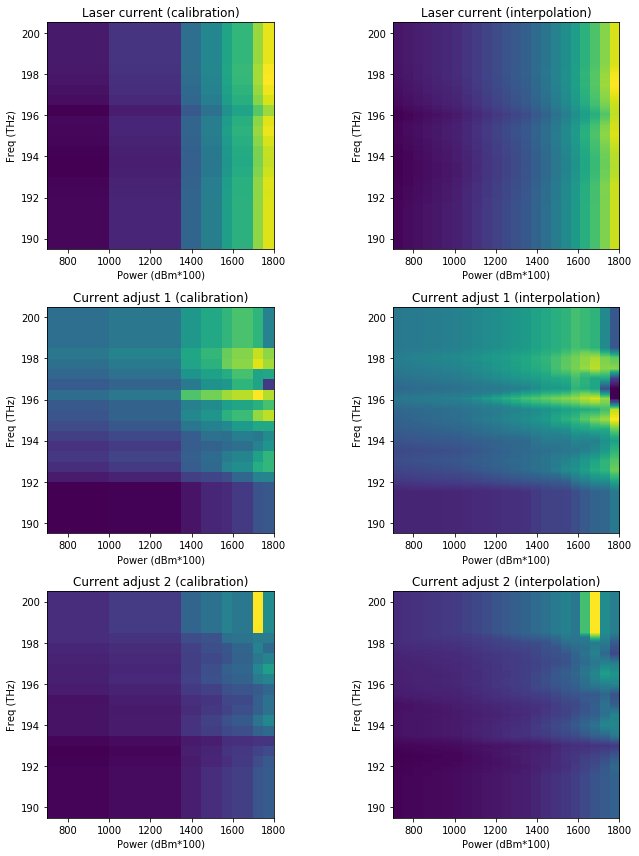

In [6]:
import csv
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

# Import data from current2 file
freqflat = []
powerflat = []
adjust1flat = []
adjust2flat = []
currentflat = []
with open('CRTNJ4P03D_Calibration/CRTNJ4P03D.current2','r') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ')
    for row in reader:
        freqflat.append(float(row[0]))
        powerflat.append(float(row[1]))
        adjust1flat.append(float(row[2]))
        adjust2flat.append(float(row[3]))
        currentflat.append(float(row[4]))
power = np.array(powerflat).reshape(9,17)
freq = np.array(freqflat).reshape(9,17)
current = np.array(currentflat).reshape(9,17)
adjust1 = np.array(adjust1flat).reshape(9,17)
adjust2 = np.array(adjust2flat).reshape(9,17)

# Define a grid that I'll create my own interpolation over
# I go from 7dBm to 18dBm in 0.5 dBm steps
#  and from 189.5 THz to 200.5 THz in 50 GHz steps
grid_x, grid_y = np.mgrid[700:1850:50, 189.5:200.51:0.05]

# Interpolate those bad boys!
current_interp = interpolate.griddata(np.transpose([powerflat,freqflat]), currentflat, (grid_x, grid_y), method='linear')
adjust1_interp = interpolate.griddata(np.transpose([powerflat,freqflat]), adjust1flat, (grid_x, grid_y), method='linear')
adjust2_interp = interpolate.griddata(np.transpose([powerflat,freqflat]), adjust2flat, (grid_x, grid_y), method='linear')

# Plot the calibration data and my interpolations side by side for a sanity check

plt.figure(figsize=(10,12))

ax1 = plt.subplot(321)
ax1.pcolormesh(power,freq,current)
ax1.set_aspect(100)
ax1.set_xlabel('Power (dBm*100)')
ax1.set_ylabel('Freq (THz)')
ax1.set_title('Laser current (calibration)')

ax2 = plt.subplot(322)
ax2.imshow(np.transpose(current_interp),origin='lower', extent=[700,1800,189.5,200.5])
ax2.set_aspect(100)
ax2.set_xlabel('Power (dBm*100)')
ax2.set_ylabel('Freq (THz)')
ax2.set_title('Laser current (interpolation)')

ax3 = plt.subplot(323)
ax3.pcolormesh(power,freq,adjust1)
ax3.set_aspect(100)
ax3.set_xlabel('Power (dBm*100)')
ax3.set_ylabel('Freq (THz)')
ax3.set_title('Current adjust 1 (calibration)')

ax4 = plt.subplot(324)
ax4.imshow(np.transpose(adjust1_interp),origin='lower', extent=[700,1800,189.5,200.5])
ax4.set_aspect(100)
ax4.set_xlabel('Power (dBm*100)')
ax4.set_ylabel('Freq (THz)')
ax4.set_title('Current adjust 1 (interpolation)')

ax5 = plt.subplot(325)
ax5.pcolormesh(power,freq,adjust2)
ax5.set_aspect(100)
ax5.set_xlabel('Power (dBm*100)')
ax5.set_ylabel('Freq (THz)')
ax5.set_title('Current adjust 2 (calibration)')

ax6 = plt.subplot(326)
ax6.imshow(np.transpose(adjust2_interp),origin='lower', extent=[700,1800,189.5,200.5])
ax6.set_aspect(100)
ax6.set_xlabel('Power (dBm*100)')
ax6.set_ylabel('Freq (THz)')
ax6.set_title('Current adjust 2 (interpolation)')

plt.tight_layout()
plt.show()

with open('CleanScanCurrents_CRTNJ4P03D.csv','w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for idx1, val1 in enumerate(grid_x):
        for idx2, val2 in enumerate(val1):
            writer.writerow([grid_x[idx1,idx2], grid_y[idx1,idx2], round(current_interp[idx1,idx2]), round(adjust2_interp[idx1,idx2]*100), round(adjust1_interp[idx1,idx2]*100)]) 

In [10]:
for power in [700, 1000, 1350, 1550, 1600, 1700, 1800]:
    freq_map = []
    sled_map = []
    filter1_map = []
    filter2_map = []
    f1power_map = []
    f2power_map = []
    current_map = []
    power_map = []
    ambient_map = []


    with open('CRTNJ4P03D_Calibration/CRTNJ4P03D_' + str(power) + '_4_18_20_45.map','r') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        for row in reader:
            freq_map.append(float(row[2]))
            sled_map.append(float(row[5]))
            filter1_map.append(float(row[8]))
            filter2_map.append(float(row[11]))
            f1power_map.append(float(row[14]))
            f2power_map.append(float(row[17]))
            current_map.append(float(row[20]))
            power_map.append(float(row[23]))
            ambient_map.append(float(row[26]))

    # write a csv file with all the pre-defined parameters needed for a clean scan
    # output the same frequencies as the .map file, which does 50GHz steps

    with open('clean_scan_parameters/'+str(power/100) +'dBm.csv','w',newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        for idx, freq in enumerate(freq_map):
    #         get indices of where in the interpolation grid this power/frequency is
            idx1 = np.where(grid_x[:,0]==power)
            idx2 = np.where(grid_y[0]==freq)
    #         first column is power. I take it from the interpolation grid, but it should be equal to the 'power' variable
            power_export = grid_x[idx1, idx2][0,0]
    #         second column is frequency. I take it from the interpolation grid, but it should be equal to the 'freq' variable
            freq_export = grid_y[idx1, idx2][0,0]
    #         third column is sled temperature, taken from .map file
            sled_export = sled_map[idx]
    #         fourth column is filter1 temperature, taken from .map file
            filter1_export = filter1_map[idx]
    #         fifth column is filter2 temperature, taken from .map file  
            filter2_export = filter2_map[idx]
    #         sixth column is laser current, taken from my interpolation of .current2 file
            current_export = round(current_interp[idx1,idx2][0,0]*0.1,1)
    #         seventh column is current adjust 1, taken from my interpolation of .current2 file
            a1_export = round(adjust2_interp[idx1,idx2][0,0]*10,1)
    #         eigth column is current adjust 2, taken from my interpolation of .current2 file
            a2_export = round(adjust1_interp[idx1,idx2][0,0]*10,1)
            writer.writerow([power_export,freq_export,sled_export,filter1_export,filter2_export,current_export,a1_export,a2_export])